# Second model:
- Process data differently
- Each first frame of each video is tokenized and taken as the REFERENCE frame -> MODALITY = tok_rgb
- Each of the next 6 frames are tokenized -> MODALITY = tok_rgb_next
- Use the given labels from the dataset and tokenize them with the same strategy -> MODALITY = coords + MODALITY = coords_next
- Use BLIP model to get .json format of the frame -> MODALITY = captions (less repeated captions)
## Losses: 
- Great losses on the training set, but awful results in the eval set. --> Overfitting due to the lack of diversity (trained with ~2000 videos only)
- 0.83 on overall loss, 0.81 and 2.41 on tok_rgb & tok_rgb_next respectively.
- Again good losses on coords coords_next and captions modalities

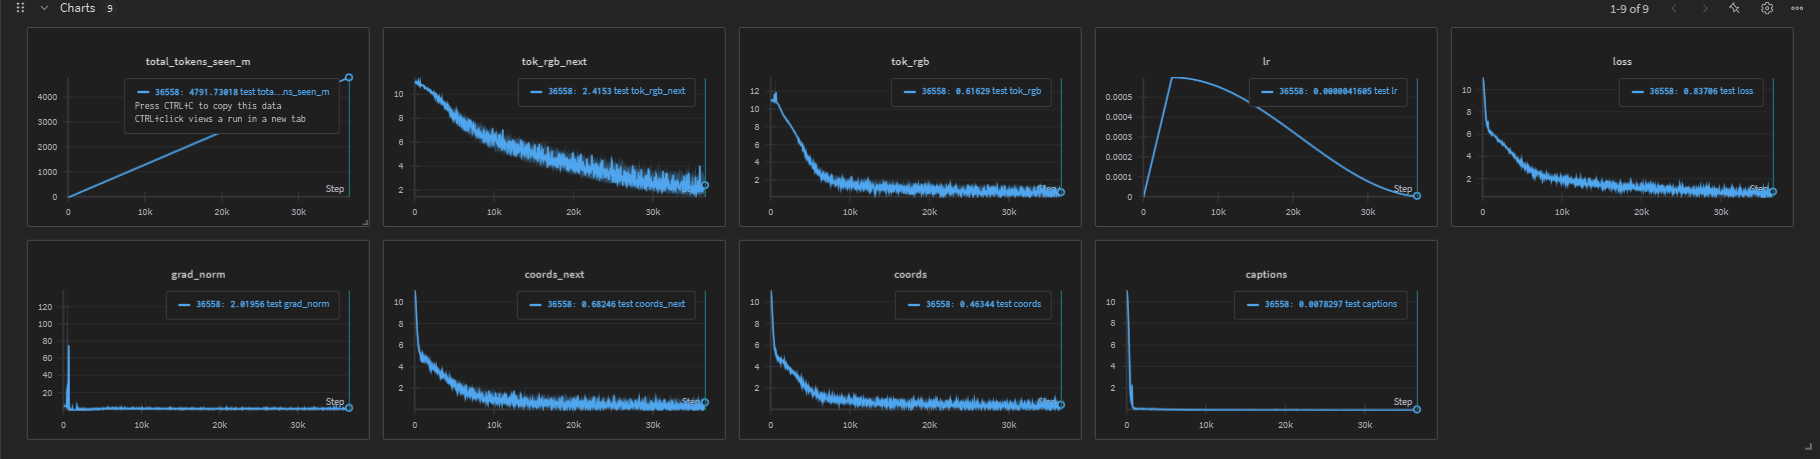

In [17]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for Cosmos tokenizer
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)
# ---------- 1. helper: tokens → PIL image --------------------
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit",
    checkpoint_dec="/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit"
).to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
from nanofm.utils.checkpoint import load_model_from_safetensors

ckpt_path = '/work/com-304/CFT/output/new/models/checkpoint-30519.safetensors' # Crashed took the checkpoint, the final had buggs couldn't load it
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

44.322304M parameters


# Helpers :

In [19]:
import numpy as np
def token_ids_to_image(token_ids, to_pil=False):
    """Cosmos token ids (L,) → tensor C,H,W (0-1) or PIL."""
    token_ids = token_ids.flatten()
    n = token_ids.numel()
    side = int(math.sqrt(n))
    img_toks = token_ids.reshape(1, side, side).to(device)

    with torch.no_grad():
        img = image_tokenizer.decode(img_toks)[0]          # bfloat16, GPU
    img = img.clamp(-1, 1).to(torch.float32).cpu()          # ← cast + move
    img = (img + 1) / 2                                     # 0-1

    if to_pil:
        return TF.to_pil_image(img)
    return img
def print_coords_sequence(coords: np.ndarray):
    """
    coords: either
      • shape (T, 3, 13) for T frames, or
      • shape (3, 13) for a single frame.
    Simply prints out each frame’s (x, y, vis) rows.
    """
    # Force into sequence form
    seq = coords[np.newaxis, ...] if coords.ndim == 2 else coords

    for t, frame in enumerate(seq):
        x, y, vis = frame
        print(f"(shape {frame.shape}):")
        print("  x coords:    ", x.tolist())
        print("  y coords:    ", y.tolist())
        print("  visibility:  ", vis.tolist())
        print("-" * 60)
import numpy as np
class CoordTokenizer:
    """
    Encoding scheme taken from your preprocessing script:

        • xy ∈ [0, 1]      → token 1 … 8190  (linear)
        • vis ∈ {0, 1}     → token 0 (invisible) or 8191 (visible)
        • 0 is still the global PAD

    A skeleton frame is stored as 39 tokens:
        26 xy tokens  +  13 visibility tokens
    """

    XY_MAX = 8190          # highest XY value
    VIS_TOK = 8191         # visibility = 1
    PAD_TOK = 0
    # ---------- decode  (int64 → float32) -------------------
    def decode(self, tokens: torch.Tensor) -> np.ndarray:
        """
        tokens: 1-D int tensor, length 39
        returns float32 array shape (3, 13) with xy in [0,1]
        """
        tokens = tokens.cpu().numpy()
        xy_tok, vis_tok = tokens[:26], tokens[26:]

        xy  = (np.clip(xy_tok, 1, self.XY_MAX) - 1) / (self.XY_MAX - 1)
        vis = (vis_tok != 0).astype(np.float32)

        frame = np.vstack([xy.reshape(2, 13), vis.reshape(1, 13)]).astype(np.float32)
        return frame   # (3, 13)

# instantiate once
coord_tokenizer = CoordTokenizer()
skeleton_edges = [
    (1, 2), (1, 3), (2, 4), (3, 5), (4, 6),
    (7, 8), (7, 9), (8, 10), (9, 11), (10, 12)
]
from PIL import Image, ImageDraw
def construct_input_from_sample(ds, idx: int, input_modality: str):
    """Return (enc_input_tokens, enc_input_positions, enc_input_modalities)
       ready for model.forward()."""
    inp = ds[idx][input_modality]   # 1-D token tensor  (L,)
    L   = inp.shape[0]
    enc_input_tokens      = inp.unsqueeze(0).to(device)  # (1, L)
    enc_input_positions   = torch.arange(L, device=device).unsqueeze(0)  # (1, L)
    enc_input_modalities  = modalities.index(input_modality) \
                            * torch.ones(1, L, dtype=torch.long, device=device)
    return enc_input_tokens, enc_input_positions, enc_input_modalities

    return enc_input_tokens, enc_input_positions, enc_input_modalities, raw_data
# ───────────────────────────────── helpers ─────────────────────────────
import tempfile, imageio.v3 as iio
from pathlib import Path

# ───────────────────────── pose → PIL (optionally) ──────────────────────────
def _draw_single_pose(frame_tokens, *, title="Pose", return_pil=False):
    coords = coord_tokenizer.decode(torch.as_tensor(frame_tokens))
    vis    = coords[2]
    x, y   = coords[0] * 256, coords[1] * 256

    canvas = Image.new("RGBA", (256, 256), (0, 0, 0, 255))
    draw   = ImageDraw.Draw(canvas)

    for j in range(13):
        if vis[j]:
            cx, cy = int(x[j]), int(y[j])
            r      = 5 if j == 0 else 3
            draw.ellipse((cx-r, cy-r, cx+r, cy+r),
                         outline="red" if j == 0 else None,
                         fill=(255, 0, 0, 255) if j else None)

    for j1, j2 in skeleton_edges:
        if vis[j1] and vis[j2]:
            draw.line([(int(x[j1]), int(y[j1])),
                       (int(x[j2]), int(y[j2]))],
                      fill="red", width=2)

    if vis[0] and vis[7] and vis[8]:
        head = (int(x[0]), int(y[0]))
        hip  = tuple(np.mean([[x[7], y[7]], [x[8], y[8]]], axis=0).astype(int))
        draw.line([head, hip], fill="red", width=2)

    if return_pil:
        return canvas

    # default behaviour: show with matplotlib
    plt.imshow(canvas); plt.axis("off"); plt.title(title); plt.show()


# ───────────────────────────── save GIF helper ──────────────────────────────
def _save_gif(pil_frames, path: str | None = None, fps: int = 2):
    """Write frames → GIF; returns Path."""
    if path is None:
        path = Path(tempfile.mkstemp(suffix=".gif")[1])
    else:
        path = Path(path)

    arr = [np.asarray(img.convert("RGB")) for img in pil_frames]
    iio.imwrite(path, arr, format="GIF", fps=fps)
    print(f"Saved GIF → {path}")
    return path
    
def _split_to_frames(arr_1d):
    """Flat tensor of length 234 → list of six length-39 tensors."""
    L = arr_1d.numel()
    assert L % 39 == 0, "coords sequence length must be multiple of 39"
    return [arr_1d[i*39:(i+1)*39] for i in range(L // 39)]

# ─────────────────────────────── show_modality ──────────────────────────────
def show_modality(tokens, modality, *, asvideo: bool = False, gif_path: str | None = None, fps: int = 2):
    """
    tokens  : (1, L) LongTensor from `construct_input_from_sample`
    modality: "captions", "tok_rgb", "tok_rgb_next", "coords", "coords_next"
    asvideo : if True and modality == "coords_next"  → save a GIF instead of
              showing the six frames separately.
    gif_path: optional filename for the GIF; if None a temp file is used.
    fps     : frames-per-second for the GIF.
    """

    # ───────────────────────── captions ────────────────────────────────
    if modality == "captions":
        print(decode_gpt2_tokens(tokens[0]))
        return

    # ───────────────────────── tok_rgb ─────────────────────────────────
    if modality == "tok_rgb":
        token_ids_to_image(tokens, to_pil=True).show()
        return

    # ───────────────────── tok_rgb_next (stills only) ──────────────────
    if modality == "tok_rgb_next":
        flat = tokens[0].cpu()
        frames = _split_to_frames(flat)   # 6 × 1600
        for t, f in enumerate(frames):
            token_ids_to_image(f, to_pil=True).show(title=f"RGB {t}")
        return

    # ───────────────────────── coords (one frame) ──────────────────────
    if modality == "coords":
        t = tokens[0].cpu()
        _draw_single_pose(t.reshape(-1))
        return

    # ───────────────────── coords_next (six frames) ────────────────────
    if modality == "coords_next":
        t = tokens[0].cpu()
        # ----- normalise any layout to list[39] -----------------------
        if t.ndim == 1:               # (234,)
            frames = _split_to_frames(t)
        elif t.ndim == 2:
            if t.shape[1] == 39:      # (6,39)
                frames = [row for row in t]
            elif t.shape[1] == 13:    # (18,13)
                frames = [t[i*3:(i+1)*3].reshape(-1) for i in range(t.shape[0]//3)]
            else:
                raise ValueError("Unrecognised coords_next shape")
        elif t.ndim == 3:             # (6,3,13)
            frames = [t[i].reshape(-1) for i in range(t.shape[0])]
        else:
            raise ValueError("Unrecognised coords_next shape")

        # ----- either show stills or make GIF -------------------------
        if not asvideo:
            for i, f in enumerate(frames):
                _draw_single_pose(f, title=f"Pose {i}")
        else:
            pil_frames = [_draw_single_pose(f, return_pil=True) for f in frames]
            _save_gif(pil_frames, gif_path, fps)
        return

    # ------------------------------------------------------------------
    raise ValueError(f"Unknown modality: {modality}")

from transformers import GPT2TokenizerFast

gpt2_tok = GPT2TokenizerFast.from_pretrained("gpt2", padding_side="right")
gpt2_tok.pad_token = gpt2_tok.eos_token          # to match your encoding step
# --------------------------------------------------------------------
# 2.  Safe decode helper
# --------------------------------------------------------------------
def decode_gpt2_tokens(tokens: torch.Tensor) -> str:
    """
    tokens: 1-D or 2-D LongTensor that may include padding (pad_token_id) or
            your loss ignore index (-100).  Returns a Python str.
    """
    # flatten & move to CPU, turn into py list of ints
    ids = tokens.detach().cpu().view(-1).tolist()

    # drop special/invalid ids (pad_token_id or -100)
    valid_ids = [t for t in ids if t >= 0 and t != gpt2_tok.pad_token_id]

    # GPT-2 decode
    return gpt2_tok.decode(valid_ids, skip_special_tokens=True).strip()

In [20]:
modalities= ["tok_rgb", "tok_rgb_next", "coords", "coords_next", "captions"]
from nanofm.data.multimodal.penn_action_multimodal_dataset_opt import (
    PennDataset
)
dataset = PennDataset(
    root_dir = "/work/com-304/CFT/output/new/",
    split    = "train",
    modalities = modalities,
    sample_from_k_augmentations = 1,
    text_tokenizer_path = "gpt2",
    text_max_length     = 256,
    transforms          = None,
)

Saved GIF → pose_future_original.gif


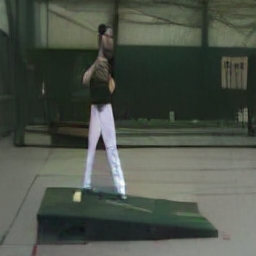

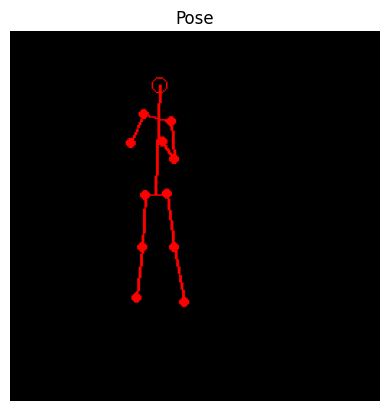

a man in a baseball uniform swinging a bat
Saved GIF → pose_future_predicted.gif


In [21]:
input_modality = 'coords_next'
sample_idx = 10

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens,"coords_next",asvideo=True,gif_path="pose_future_original.gif",fps=5)
## New values :
input_modality = 'tok_rgb'

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'coords'
num_steps, temp, top_p, top_k = 1, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

target_mod = 'captions'
num_steps, temp, top_p, top_k = 6, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)
target_mod = 'coords_next'
num_steps, temp, top_p, top_k = 6, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens,"coords_next",asvideo=True,gif_path="pose_future_predicted.gif",fps=5)

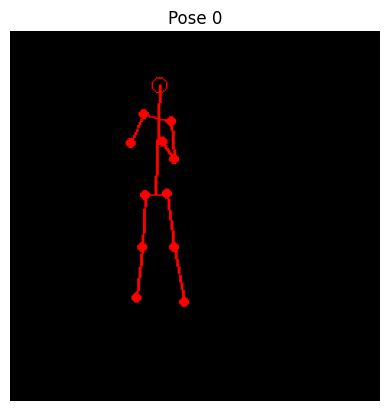

In [22]:
input_modality = 'coords'
sample_idx =10

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
#show_modality(x_tokens,"coords_next",asvideo=True,gif_path="pose_future.gif",fps=3)
show_modality(x_tokens, target_mod)

In [23]:
dataset_eval = PennDataset(
    root_dir = "/work/com-304/CFT/output/new/",
    split    = "eval",
    modalities = modalities,
    sample_from_k_augmentations = 1,
    text_tokenizer_path = "gpt2",
    text_max_length     = 256,
    transforms          = None,
)

# Evaluation

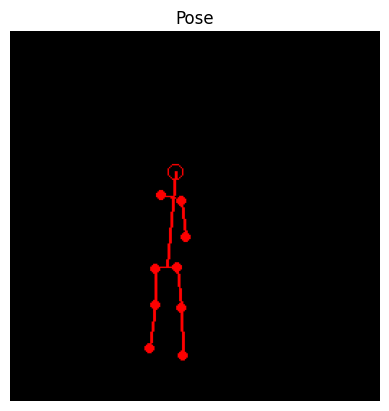

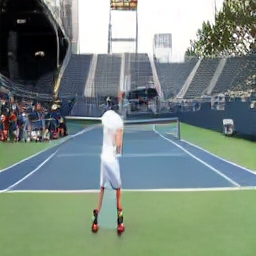

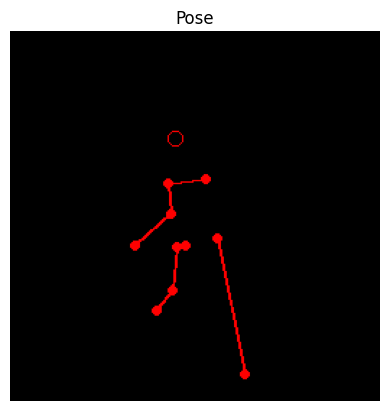

In [24]:
input_modality = 'coords'
sample_idx =150

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset_eval, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
input_modality = 'tok_rgb'

x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset_eval, sample_idx, input_modality)
show_modality(x_tokens, input_modality)
target_mod = 'coords'
num_steps, temp, top_p, top_k = 1, 0.0001, 0.0, 10

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

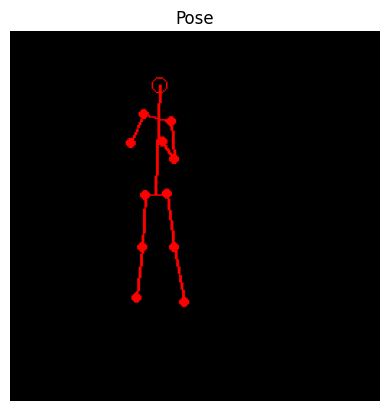

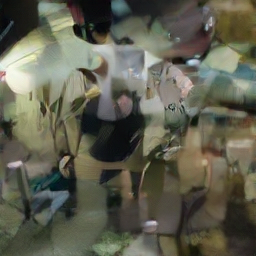

In [25]:
input_modality = 'coords'
sample_idx = 10
x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)

target_mod = 'tok_rgb'
num_steps, temp, top_p, top_k = 1, 0.0001, 0.0, 0.0

pred_tokens, x_tokens, x_positions, x_modalities = model.generate_one_modality_roar(
    x_tokens, x_positions, x_modalities, target_mod=target_mod,
    num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k,
)
show_modality(pred_tokens, target_mod)

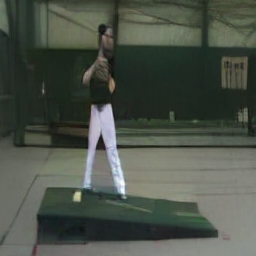

In [26]:
input_modality = 'tok_rgb'
sample_idx = 10
x_tokens, x_positions, x_modalities = construct_input_from_sample(dataset, sample_idx, input_modality)
show_modality(x_tokens, input_modality)